In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 35.06 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [2]:
import os
import tensorflow as tf
import tensorflow_hub as hub
from keras.utils import plot_model
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
import string
import random

In [3]:
# get the file path of training, testing and validation dataset

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

# Data preprocessing

In [4]:
# Create a function that take a filename and return a list of all lines in a file
def get_lines(filename):
  with open(filename) as f:
    return f.readlines()

In [5]:
train_lines = get_lines(filenames[2])
train_lines[:20]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [6]:
# Number of lines
len(train_lines)

35135

In [7]:

def preprocess_text_with_line_numbers(filename):
  """
  Create a function that read file and returns a list of dictionaries of abstract line data
          [{'line_number':0,
          'target': 'BACKGROUND',
          'text': 'Emotional eating is associated with overeating and the development of obesity',
          'total_lines: 11}
        ...]
  """
  input_lines = get_lines(filename)
  returned_list = []
  lines = ""

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      lines = ""

    elif line.isspace():
      line_split = lines.splitlines()

      for line_number, line in enumerate(line_split):
        line_data = {}
        target_text_split = line.split("\t")
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1]
        line_data['line_number'] = line_number
        line_data['total_lines'] = len(line_split) - 1
        returned_list.append(line_data)

    else:
      lines += line

  return returned_list


In [8]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(filenames[2])
val_samples = preprocess_text_with_line_numbers(filenames[0])
test_samples = preprocess_text_with_line_numbers(filenames[1])

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 346 ms, sys: 87.3 ms, total: 433 ms
Wall time: 431 ms


(30135, 180040, 30212)

In [9]:
# Check the first samples of training set
train_samples[:10]

[{'target': 'BACKGROUND',
  'text': 'This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .',
  'line_number': 0,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .',
  'line_number': 1,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'Liver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  'line_number': 2,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'Survival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ %

In [10]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,This study analyzed liver function abnormaliti...,0,8
1,RESULTS,A post hoc analysis was conducted with the use...,1,8
2,RESULTS,Liver function tests ( LFTs ) were measured at...,2,8
3,RESULTS,Survival analyses were used to assess the asso...,3,8
4,RESULTS,The percentage of patients with abnormal LFTs ...,4,8


In [11]:
train_df['target'].value_counts()

METHODS        9897
RESULTS        9713
CONCLUSIONS    4571
BACKGROUND     3621
OBJECTIVE      2333
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

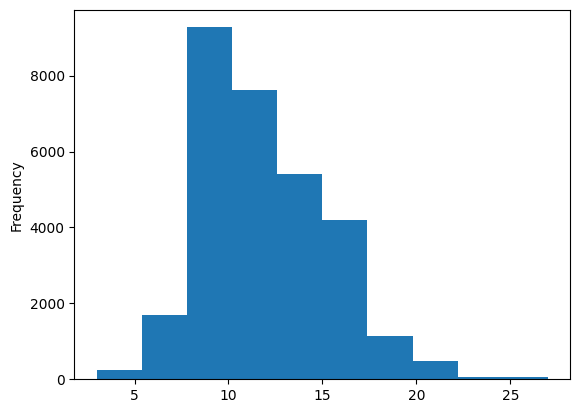

In [12]:
train_df.total_lines.plot.hist()

In [13]:
# sentences dataset
train_sentences = train_df['text'].tolist()
valid_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(valid_sentences), len(test_sentences)

(30135, 180040, 30212)

In [14]:
train_sentences[:5]

['This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .',
 'A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .',
 'Liver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
 'Survival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
 "The percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up ."]

In [15]:
# chars dataset
def split_chars(text):
  return " ".join(list(text))

train_chars = [split_chars(sentence) for sentence in train_sentences]
valid_chars = [split_chars(sentence) for sentence in valid_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
len(train_chars), len(valid_chars), len(test_chars)

(30135, 180040, 30212)

In [16]:
train_chars[:5]

['T h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t t e d   w i t h   s e v e r e   a c u t e   d e c o m p e n s a t e d   h e a r t   f a i l u r e   (   A D H F   )   .',
 'A   p o s t   h o c   a n a l y s i s   w a s   c o n d u c t e d   w i t h   t h e   u s e   o f   d a t a   f r o m   t h e   E v a l u a t i o n   S t u d y   o f   C o n g e s t i v e   H e a r t   F a i l u r e   a n d   P u l m o n a r y   A r t e r y   C a t h e t e r i z a t i o n   E f f e c t i v e n e s s   (   E S C A P E   )   .',
 'L i v e r   f u n c t i o n   t e s t s   (   L F T s   )   w e r e   m e a s u r e d   a t   @   t i m e   p o i n t s   f r o m   b a s e l i n e   ,   a t   d i s c h a r g e   ,   a n d   u p   t o   @   m o n t h s   f o l l o w - u p   .',
 'S u r v i v a l   a n a l y s e s   w e r e   u s e d   t o   a s s e s s   t h e   a s s o c i a t i o n   b e t w e 

In [17]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1, 1))

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encodedd = label_encoder.transform(test_df['target'].to_numpy())

train_labels_one_hot, train_labels_encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]),
 array([0, 4, 4, ..., 4, 4, 1]))

## Create char vectorizer

In [18]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

148.45996349759415

(array([1.3509e+04, 1.3944e+04, 2.2690e+03, 3.4000e+02, 5.2000e+01,
        1.8000e+01, 3.0000e+00]),
 array([  2.        , 127.28571429, 252.57142857, 377.85714286,
        503.14285714, 628.42857143, 753.71428571, 879.        ]),
 <BarContainer object of 7 artists>)

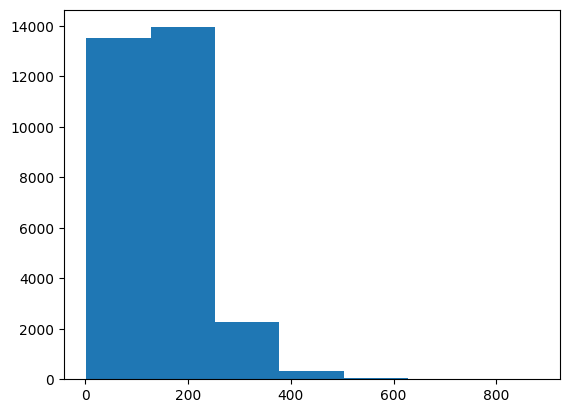

In [19]:
plt.hist(char_lens, bins=7)

In [20]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

288

In [21]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [22]:
# Create a char-level token vectorizer
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                                                               output_sequence_length=output_seq_char_len,
                                                                               name='char_vectorizer')

In [23]:
char_vectorizer.adapt(train_chars)

In [24]:
random_char_sample = random.choice(train_chars)
random_char_sample, char_vectorizer(random_char_sample)

('A m o n g   o l d e r   w o m e n   e n r o l l e d   o n t o   a   c l i n i c a l   t r i a l   ,   c o m o r b i d i t y   w a s   a s s o c i a t e d   w i t h   s h o r t e r   O S   ,   b u t   n o t   t o x i c i t y   o r   r e l a p s e   .',
 <tf.Tensor: shape=(288,), dtype=int64, numpy=
 array([ 5, 15,  7,  6, 18,  7, 12, 10,  2,  8, 20,  7, 15,  2,  6,  2,  6,
         8,  7, 12, 12,  2, 10,  7,  6,  3,  7,  5, 11, 12,  4,  6,  4, 11,
         5, 12,  3,  8,  4,  5, 12, 11,  7, 15,  7,  8, 22,  4, 10,  4,  3,
        19, 20,  5,  9,  5,  9,  9,  7, 11,  4,  5,  3,  2, 10, 20,  4,  3,
        13,  9, 13,  7,  8,  3,  2,  8,  7,  9, 22, 16,  3,  6,  7,  3,  3,
         7, 24,  4, 11,  4,  3, 19,  7,  8,  8,  2, 12,  5, 14,  9,  2,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,

## Create a character-level embedding

In [25]:
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab)

28

In [26]:
char_embedding = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                                       output_dim=25,
                                       mask_zero=True,
                                       name='char_embed')

## Character Model

In [28]:
# create a character baseline
num_classes = 5
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((valid_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

inputs = tf.keras.layers.Input(shape=(1, ), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embedding(x)
x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model_char = tf.keras.Model(inputs, outputs)

model_char.compile(loss='categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['accuracy'])

history_model_char = model_char.fit(train_char_dataset,
                                    steps_per_epoch=int(0.1 * len(train_char_dataset)),
                                    epochs=5,
                                    validation_data=val_char_dataset,
                                    validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/5
94/94 [==============================] - 6s 31ms/step - loss: 1.4691 - accuracy: 0.3826 - val_loss: 1.4427 - val_accuracy: 0.3835
Epoch 2/5
94/94 [==============================] - 3s 30ms/step - loss: 1.4053 - accuracy: 0.4461 - val_loss: 1.3670 - val_accuracy: 0.4571
Epoch 3/5
94/94 [==============================] - 2s 21ms/step - loss: 1.3391 - accuracy: 0.4564 - val_loss: 1.2647 - val_accuracy: 0.4907
Epoch 4/5
94/94 [==============================] - 3s 32ms/step - loss: 1.2442 - accuracy: 0.4847 - val_loss: 1.1791 - val_accuracy: 0.5349
Epoch 5/5
94/94 [==============================] - 2s 21ms/step - loss: 1.1448 - accuracy: 0.5322 - val_loss: 1.1148 - val_accuracy: 0.5520


## Sentences Model

In [29]:

train_token_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_token_dataset = tf.data.Dataset.from_tensor_slices((valid_sentences, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="use")

inputs = tf.keras.layers.Input(shape=(), dtype=tf.string)
x = sentence_encoder_layer(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_sentence = tf.keras.Model(inputs, outputs)

model_sentence.compile(loss='categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])

history_model_sentence = model_sentence.fit(train_token_dataset,
                                            epochs=5,
                                            steps_per_epoch=int(0.1 * len(train_token_dataset)),
                                            validation_data=valid_token_dataset,
                                            validation_steps=int(0.1 * len(valid_token_dataset)))


Epoch 1/5
94/94 [==============================] - 13s 86ms/step - loss: 1.3170 - accuracy: 0.4787 - val_loss: 1.1187 - val_accuracy: 0.5741
Epoch 2/5
94/94 [==============================] - 6s 62ms/step - loss: 0.9963 - accuracy: 0.6160 - val_loss: 0.9354 - val_accuracy: 0.6363
Epoch 3/5
94/94 [==============================] - 7s 71ms/step - loss: 0.9045 - accuracy: 0.6546 - val_loss: 0.8705 - val_accuracy: 0.6613
Epoch 4/5
94/94 [==============================] - 6s 61ms/step - loss: 0.8546 - accuracy: 0.6719 - val_loss: 0.8426 - val_accuracy: 0.6721
Epoch 5/5
94/94 [==============================] - 8s 81ms/step - loss: 0.8203 - accuracy: 0.6905 - val_loss: 0.8214 - val_accuracy: 0.6851


## Hybrid Model(character + sentences)

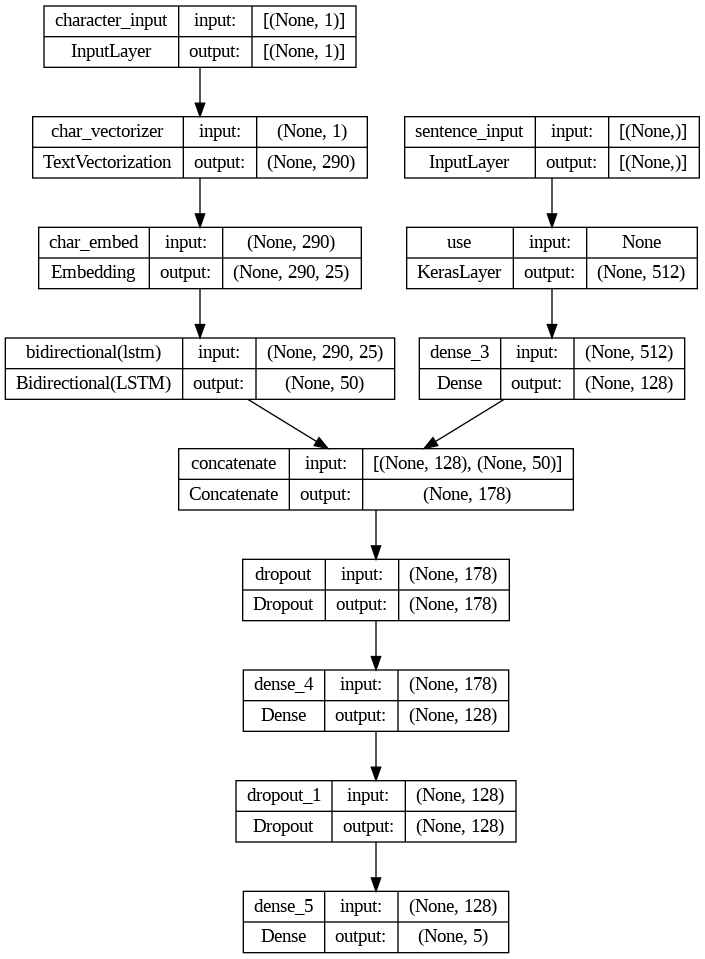

In [29]:
# tensorfow dataset training
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#tensorflow dataset validation
valid_char_token_data = tf.data.Dataset.from_tensor_slices((valid_sentences, valid_chars))
valid_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
valid_char_token_dataset = tf.data.Dataset.zip((valid_char_token_data, valid_char_token_labels))
valid_char_token_dataset = valid_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Create model character
char_inputs = tf.keras.layers.Input(shape=(1, ), dtype=tf.string, name="character_input")
char_vector = char_vectorizer(char_inputs)
char_embed = char_embedding(char_vector)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embed)
model_char = tf.keras.Model(char_inputs, char_bi_lstm)

# Create model sentence
sent_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name="sentence_input")
sent_use = sentence_encoder_layer(sent_inputs)
sent_outputs = tf.keras.layers.Dense(128, activation='relu')(sent_use)
model_sent = tf.keras.Model(sent_inputs, sent_outputs)


# Concatenate model_char and model_sent outputs
concat_sent_char = tf.keras.layers.Concatenate()([model_sent.output, model_char.output])

# output layers
x = tf.keras.layers.Dropout(0.5)(concat_sent_char)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_hybrid = tf.keras.Model([model_sent.input,model_char.input],
                              outputs)
plot_model(model_hybrid, show_shapes=True)

In [30]:
model_hybrid.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

history_model_hybrid = model_hybrid.fit(train_char_token_dataset,
                                        epochs=5,
                                        steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                                        validation_data=valid_char_token_dataset,
                                        validation_steps=int(0.1 * len(valid_char_token_dataset)))

Epoch 1/5
94/94 [==============================] - 81s 748ms/step - loss: 1.4289 - accuracy: 0.4402 - val_loss: 1.2563 - val_accuracy: 0.5913
Epoch 2/5
94/94 [==============================] - 56s 599ms/step - loss: 1.2452 - accuracy: 0.6054 - val_loss: 1.1870 - val_accuracy: 0.6449
Epoch 3/5
94/94 [==============================] - 66s 711ms/step - loss: 1.2014 - accuracy: 0.6316 - val_loss: 1.1548 - val_accuracy: 0.6724
Epoch 4/5
94/94 [==============================] - 66s 711ms/step - loss: 1.1844 - accuracy: 0.6543 - val_loss: 1.1405 - val_accuracy: 0.6829
Epoch 5/5
94/94 [==============================] - 78s 834ms/step - loss: 1.1761 - accuracy: 0.6669 - val_loss: 1.1284 - val_accuracy: 0.6916


## Feature engineer (total_line and line_number)

<Axes: ylabel='Frequency'>

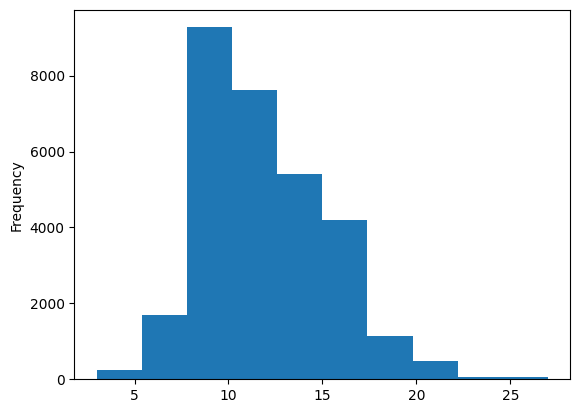

In [30]:
train_df['total_lines'].plot.hist()

In [31]:
np.percentile(train_df['total_lines'], 99)

21.0

In [32]:
# one-hot encoding total_lines with 21 of depth
train_total_line_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), 21)
valid_total_line_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), 21)
test_total_line_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), 21)
train_total_line_one_hot.shape, valid_total_line_one_hot.shape, test_total_line_one_hot.shape

(TensorShape([30135, 21]), TensorShape([180040, 21]), TensorShape([30212, 21]))

<Axes: ylabel='Frequency'>

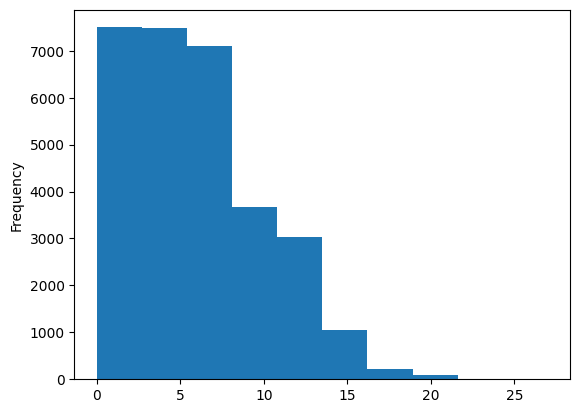

In [33]:
train_df['line_number'].plot.hist()

In [34]:
np.percentile(train_df['line_number'], 98)

15.0

In [35]:
# one-hot encoding line_number with depth of 15
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), 15)
valid_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), 15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), 15)
train_line_number_one_hot.shape, valid_line_number_one_hot.shape, test_line_number_one_hot.shape

(TensorShape([30135, 15]), TensorShape([180040, 15]), TensorShape([30212, 15]))

## Tribrid Model(character + sentences + (line_number + total_lines))

In [36]:
# Create tensorflow dataset
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars, train_line_number_one_hot, train_total_line_one_hot))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

valid_tribrid_data = tf.data.Dataset.from_tensor_slices((valid_sentences, valid_chars, valid_line_number_one_hot, valid_total_line_one_hot))
valid_tribrid_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
valid_tribrid_dataset = tf.data.Dataset.zip((valid_tribrid_data, valid_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

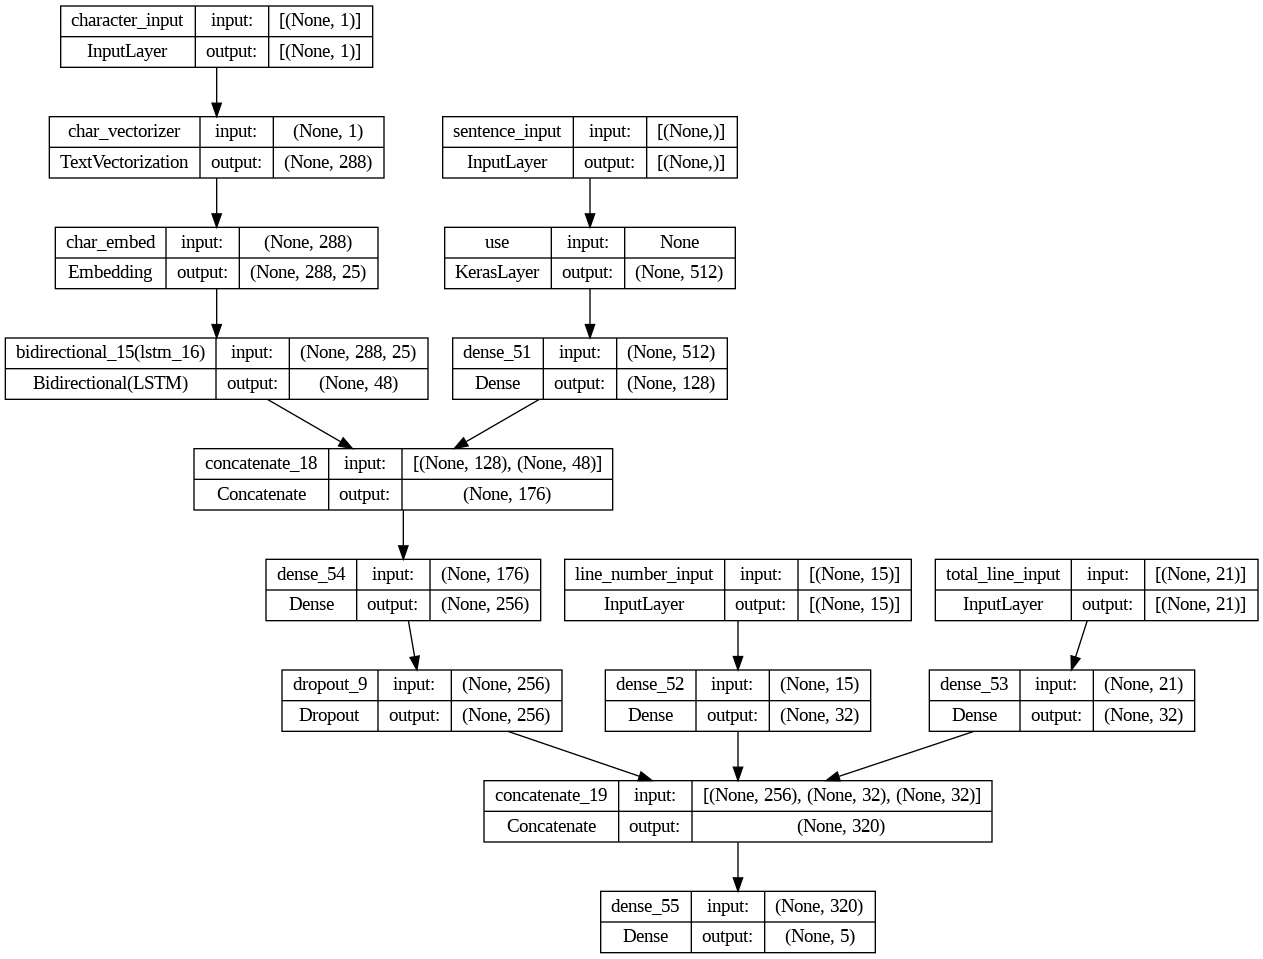

In [57]:
# sentences model
sent_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name="sentence_input")
sent_use = sentence_encoder_layer(sent_inputs)
sent_outputs = tf.keras.layers.Dense(128, activation='relu')(sent_use)
model_sentence = tf.keras.Model(sent_inputs, sent_outputs)

# character model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="character_input")
char_vector = char_vectorizer(char_inputs)
char_embed = char_embedding(char_vector)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embed)
model_character = tf.keras.Model(char_inputs, char_bi_lstm)

#line number model
line_number_inputs = tf.keras.layers.Input(shape=(15,), name="line_number_input")
line_number_outputs = tf.keras.layers.Dense(32, activation="relu")(line_number_inputs)
model_line_number = tf.keras.Model(line_number_inputs, line_number_outputs)

# Total line model
total_line_inputs = tf.keras.layers.Input(shape=(21, ), name="total_line_input")
total_line_outputs = tf.keras.layers.Dense(32, activation="relu")(total_line_inputs)
model_total_line = tf.keras.Model(total_line_inputs, total_line_outputs)

# Concatenate the output of all
concat_char_sent = tf.keras.layers.Concatenate()([model_sentence.output, model_character.output])

x = tf.keras.layers.Dense(256, activation='relu')(concat_char_sent)
x = tf.keras.layers.Dropout(0.5)(x)

concat_all = tf.keras.layers.Concatenate()([x,
                                            model_line_number.output,
                                            model_total_line.output])

# Output layers
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(concat_all)

model_tribrid = tf.keras.Model([model_sentence.input,
                                model_character.inputs,
                                model_line_number.input,
                                model_total_line.input], outputs)

plot_model(model_tribrid, show_shapes=True)

In [58]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

model_tribrid.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])

history_model_tribrid = model_tribrid.fit(train_tribrid_dataset,
                                          epochs=20,
                                          steps_per_epoch=len(train_tribrid_dataset),
                                          validation_data=valid_tribrid_dataset,
                                          validation_steps=len(valid_tribrid_dataset),
                                          callbacks=[early_callback])

Epoch 1/20
942/942 [==============================] - 201s 202ms/step - loss: 1.0479 - accuracy: 0.7561 - val_loss: 0.9592 - val_accuracy: 0.8204
Epoch 2/20
942/942 [==============================] - 148s 157ms/step - loss: 0.9463 - accuracy: 0.8292 - val_loss: 0.9397 - val_accuracy: 0.8336
Epoch 3/20
942/942 [==============================] - 154s 164ms/step - loss: 0.9219 - accuracy: 0.8485 - val_loss: 0.9325 - val_accuracy: 0.8374
Epoch 4/20
942/942 [==============================] - 148s 157ms/step - loss: 0.9024 - accuracy: 0.8633 - val_loss: 0.9300 - val_accuracy: 0.8382
Epoch 5/20
942/942 [==============================] - 149s 158ms/step - loss: 0.8835 - accuracy: 0.8771 - val_loss: 0.9317 - val_accuracy: 0.8359
Epoch 6/20
942/942 [==============================] - 148s 157ms/step - loss: 0.8656 - accuracy: 0.8922 - val_loss: 0.9403 - val_accuracy: 0.8290
Epoch 7/20
942/942 [==============================] - 147s 157ms/step - loss: 0.8512 - accuracy: 0.9020 - val_loss: 0.9442 -

<Axes: >

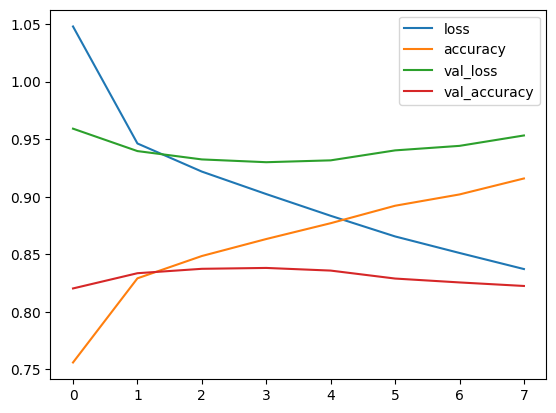

In [60]:
pd.DataFrame(history_model_tribrid.history).plot()

Text(0.5, 1.0, 'tribrid accuracy')

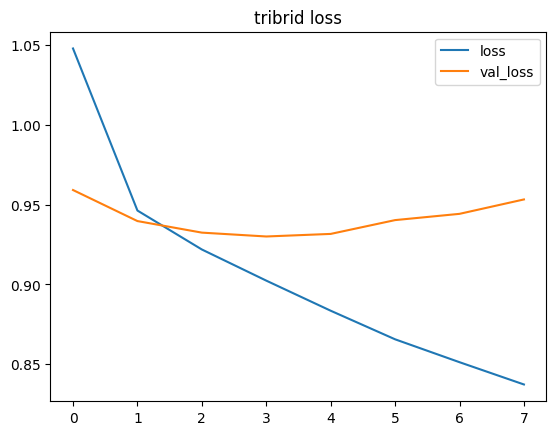

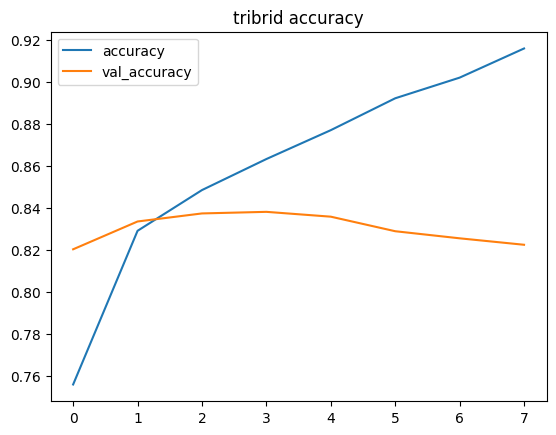

In [68]:
plt.plot(history_model_tribrid.history["loss"], label="loss")
plt.plot(history_model_tribrid.history["val_loss"], label="val_loss")
plt.legend(loc="upper right")
plt.title("tribrid loss")
plt.figure()
plt.plot(history_model_tribrid.history['accuracy'], label='accuracy')
plt.plot(history_model_tribrid.history['val_accuracy'], label='val_accuracy')
plt.legend(loc='upper left')
plt.title("tribrid accuracy")

In [70]:
# Create tensorflow dataset
test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars, test_line_number_one_hot, test_total_line_one_hot))
test_tribrid_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data, test_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)



test_accuracy = model_tribrid.evaluate(test_tribrid_dataset)

945/945 [==============================] - 23s 24ms/step - loss: 0.9484 - accuracy: 0.8244
